In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle as pkl
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from pygam.terms import s,l,f
from pygam.pygam import LogisticGAM
from sklearn.metrics import (precision_score,f1_score,recall_score,accuracy_score,make_scorer)

from sklearn.inspection import permutation_importance

/home/sergio/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#### Load dataset with no reference categories

In [3]:
df = pd.read_csv("../datasets/dataset_preprocessed.csv") 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118726 entries, 0 to 118725
Data columns (total 91 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   is_canceled                     118726 non-null  int64  
 1   lead_time                       118726 non-null  int64  
 2   arrival_date_week_number        118726 non-null  int64  
 3   arrival_date_day_of_month       118726 non-null  int64  
 4   stays_in_weekend_nights         118726 non-null  int64  
 5   stays_in_week_nights            118726 non-null  int64  
 6   adults                          118726 non-null  int64  
 7   children                        118726 non-null  int64  
 8   babies                          118726 non-null  int64  
 9   previous_cancellations          118726 non-null  int64  
 10  previous_bookings_not_canceled  118726 non-null  int64  
 11  booking_changes                 118726 non-null  int64  
 12  days_in_waiting_

Split into train and test

In [4]:
df = df.drop(["hotel_City Hotel"],axis=1)

labels = df.iloc[:,0]
features = df.iloc[:,1:]

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.2, random_state = 0)
print(X_train.shape,X_test.shape, y_train.shape, y_test.shape)

(94980, 89) (23746, 89) (94980,) (23746,)


## Feature Importances

#### Load the trained models

In [10]:
gb = pkl.load(open('models/gb.pkl', 'rb'))

/home/sergio/anaconda3/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator DummyClassifier from version 0.22.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sergio/anaconda3/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.22.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sergio/anaconda3/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator GradientBoostingClassifier from version 0.22.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


#### Features Importances 

Sklearn feature importance. Dataset containing all variables. Classical Dummy Encoding (Model: GB)

In [19]:
from sklearn.inspection import permutation_importance
from sklearn.ensemble import GradientBoostingClassifier

result = permutation_importance(gb, X_test, y_test, n_repeats=10, n_jobs=-1)
results = pd.DataFrame([],columns=['mean','std'])

cols = X_test.columns.tolist()
for i in result.importances_mean.argsort()[::-1]:
    print(f"{cols[i]}: "
          f"{result.importances_mean[i]:.3f}"
          f" +/- {result.importances_std[i]:.3f}")
    results.loc[cols[i]] = [result.importances_mean[i],result.importances_std[i]]

lead_time: 0.074 +/- 0.001
country_PRT: 0.059 +/- 0.001
total_of_special_requests: 0.046 +/- 0.002
adr: 0.045 +/- 0.001
market_segment_Online TA: 0.040 +/- 0.001
assigned_room_type_A: 0.032 +/- 0.001
reserved_room_type_A: 0.029 +/- 0.001
deposit_type_Non Refund: 0.026 +/- 0.001
arrival_date_week_number: 0.025 +/- 0.001
previous_cancellations: 0.021 +/- 0.001
required_car_parking_spaces: 0.014 +/- 0.001
customer_type_Transient: 0.013 +/- 0.001
hotel_Resort Hotel: 0.011 +/- 0.001
arrival_date_day_of_month: 0.010 +/- 0.001
booking_changes: 0.007 +/- 0.001
stays_in_week_nights: 0.006 +/- 0.001
meal_SC: 0.004 +/- 0.000
previous_bookings_not_canceled: 0.003 +/- 0.000
assigned_room_type_D: 0.003 +/- 0.001
stays_in_weekend_nights: 0.003 +/- 0.001
customer_type_Transient-Party: 0.003 +/- 0.001
adults: 0.002 +/- 0.000
country_ESP: 0.002 +/- 0.000
country_ITA: 0.001 +/- 0.000
reserved_room_type_D: 0.001 +/- 0.000
country_DEU: 0.001 +/- 0.000
assigned_room_type_E: 0.001 +/- 0.000
children: 0.001 +

In [21]:
cols = X_test.columns.tolist()
cat_cols = ['hotel','meal','country','market_segment','reserved_room_type',
            'assigned_room_type','deposit_type','customer_type']

results_updated = pd.DataFrame([],columns=['mean','std'])

z=0
for c in cols:
    perm_cols = []
    if c.startswith(tuple(cat_cols)):
        perm_cols = [i for i in cols if i.startswith(cat_cols[z] + '_')]
        new_df = results.loc[perm_cols,:]
        m = new_df['mean'].mean() #mean of all of them
        sd = new_df['std'].mean()
        results_updated.loc[cat_cols[z]] = [m,sd]
        z += 1
        
        if z == len(cat_cols):
            break
    else:
        new_df = results.loc[c,:]
        r = new_df
        results_updated.loc[c] = [r['mean'],r['std']]

results_updated = results_updated.sort_values(by=['mean'],ascending=False)
results_updated

,mean,std
lead_time,0.073916,0.001466
total_of_special_requests,0.046020,0.001965
adr,0.045111,0.001316
arrival_date_week_number,0.024918,0.001464
previous_cancellations,0.020989,0.000586
required_car_parking_spaces,0.013855,0.000806
hotel,0.011017,0.000953
arrival_date_day_of_month,0.009581,0.000874
deposit_type,0.009051,0.000379
booking_changes,0.006717,0.000639


In [22]:
results_updated.to_csv('feature_importances/sklearn_classical_dummy_feature_importances.csv')

Manual Permutation Feature Importance (Model: GB)

In [11]:
#Function which takes the model, the dataset, the list of columns to permute and the number or permutation.
#Creates the random permutations and runs the algorithm over the new dataset with the new columns.
#Computes the mean acc and std and returns them. This is done for every single attribute.

def perm_importance(model,X,y_truth,perm_cols,n,score=accuracy_score):
    X_data = X.copy()
    
    y_pred = model.predict(X_data)
    s0 = score(y_truth,y_pred)
    
    s_list = []
    for i in range(0,n):
        X_feats = X_data[perm_cols]
        
        index = X_feats.index
        index_permuted = np.random.permutation(index.values)
        X_feats = X_feats.loc[index_permuted,:] 
        X_data.loc[:,perm_cols] = X_feats.values.tolist() # don't drop variables, but substitute the values
                                                          # and take .values.tolist(), so index is ignored
        y_pred = model.predict(X_data)
        s = score(y_truth,y_pred)
        
        s_list.append(s0-s)
        
    importance_mean = np.mean(s_list,axis=0)
    importance_std = np.std(s_list,axis=0)
    
    # alternatively let you give back the whole list
    return importance_mean,importance_std;

In [21]:
#CATEG VARS: hotel, meal, country, market_segment, reserved_room_type, 
#assigned_room_type, deposit_type, customer_type

n = 10
cols = X_test.columns.tolist()
cat_cols = ['hotel','meal','country','market_segment','reserved_room_type',
            'assigned_room_type','deposit_type','customer_type']

acc_results = {}

z = 0
for c in cols:
    perm_cols = []
    if c.startswith(tuple(cat_cols)):
        perm_cols = [i for i in cols if i.startswith(cat_cols[z] + '_')]
          
        result_mean, result_std = perm_importance(gb,X_test,y_test,perm_cols,n)
        acc_results[cat_cols[z]] = [result_mean,result_std]
        z += 1
        if z == len(cat_cols):
            break

    else:
        perm_cols.append(c)       
        result_mean,result_std = perm_importance(gb,X_test,y_test,perm_cols,n)
        acc_results[c] = [result_mean,result_std]
        
feat_importances = pd.DataFrame.from_dict(acc_results)
feat_importances = feat_importances.transpose() 
feat_importances = feat_importances.rename(columns={0:'mean',1:'std'})
feat_importances = feat_importances.sort_values(by=['mean'],ascending=False)
feat_importances

,mean,std
country,0.082877,0.001293
lead_time,0.073848,0.000490
total_of_special_requests,0.046425,0.001724
adr,0.045978,0.001594
market_segment,0.045435,0.001104
assigned_room_type,0.039952,0.001433
reserved_room_type,0.035181,0.000689
deposit_type,0.033349,0.001333
arrival_date_week_number,0.025002,0.001131
previous_cancellations,0.020547,0.000790


PIMP Manual Permutation Feature Importance (Model: GB)

In [25]:
def pimp(X_train,X_test,y_train,y_test,n):
    importances = pd.DataFrame()
    
    for i in range(0,n):
        index = y_train.index
        index_permuted = np.random.permutation(index.values)
        y_train = y_train.loc[index_permuted,] 

        gb = GradientBoostingClassifier(learning_rate=0.2,n_estimators=300,subsample=0.8,max_depth=11)
        gb.fit(X_train,y_train)
        
        m = 10
        cols = X_test.columns.tolist()
        cat_cols = ['hotel','meal','country','market_segment','reserved_room_type',
                    'assigned_room_type','deposit_type','customer_type']

        acc_results = {}

        z = 0
        for c in cols:
            perm_cols = []
            if c.startswith(tuple(cat_cols)):
                perm_cols = [i for i in cols if i.startswith(cat_cols[z] + '_')]
                z += 1

                if z == len(cat_cols):
                    break

                result_mean, result_std = perm_importance(gb,X_test,y_test,perm_cols,m)
                acc_results[cat_cols[z]] = result_mean

            else:
                perm_cols.append(c)

                result_mean,result_std = perm_importance(gb,X_test,y_test,perm_cols,m)
                acc_results[c] = result_mean

        feat_importances = pd.DataFrame.from_dict(acc_results,orient='index',columns=[i])
        #feat_importances = feat_importances.transpose() 
        #feat_importances = feat_importances.rename(columns={0:'mean'})
        #feat_importances = feat_importances.sort_values(by=[n],ascending=False)
        importances = pd.concat([importances, feat_importances],axis=1)
        print(importances)
    
    return importances

In [26]:
n = 10

importances = pimp(X_train,X_test,y_train,y_test,n)
importances = importances.loc[feat_importances.index,:]
importances

                                       0
lead_time                      -0.005500
arrival_date_week_number       -0.004691
arrival_date_day_of_month      -0.004594
stays_in_weekend_nights        -0.001832
stays_in_week_nights            0.001289
adults                         -0.002177
children                       -0.000236
babies                          0.000088
previous_cancellations          0.003053
previous_bookings_not_canceled -0.001537
booking_changes                 0.000842
days_in_waiting_list           -0.000387
adr                            -0.007951
required_car_parking_spaces    -0.003352
total_of_special_requests      -0.013767
meal                            0.003070
country                        -0.005458
market_segment                 -0.016222
reserved_room_type             -0.017068
assigned_room_type             -0.004565
deposit_type                   -0.009046
customer_type                   0.007189
                                       0         1
lead_t

                                       0         1         2         3  \
lead_time                      -0.005500 -0.002813 -0.013590 -0.006708   
arrival_date_week_number       -0.004691 -0.012895 -0.012149 -0.005386   
arrival_date_day_of_month      -0.004594 -0.011745 -0.007622 -0.006477   
stays_in_weekend_nights        -0.001832 -0.002969 -0.002371 -0.004085   
stays_in_week_nights            0.001289 -0.003971 -0.008342 -0.002341   
adults                         -0.002177 -0.002026 -0.003714 -0.006182   
children                       -0.000236  0.000093 -0.001714  0.000164   
babies                          0.000088  0.000114 -0.000202 -0.000476   
previous_cancellations          0.003053 -0.000126 -0.000817  0.000733   
previous_bookings_not_canceled -0.001537 -0.002009 -0.000118  0.000880   
booking_changes                 0.000842 -0.004502  0.000392 -0.002822   
days_in_waiting_list           -0.000387  0.000442 -0.000632  0.001676   
adr                            -0.0079

                                       0         1         2         3  \
lead_time                      -0.005500 -0.002813 -0.013590 -0.006708   
arrival_date_week_number       -0.004691 -0.012895 -0.012149 -0.005386   
arrival_date_day_of_month      -0.004594 -0.011745 -0.007622 -0.006477   
stays_in_weekend_nights        -0.001832 -0.002969 -0.002371 -0.004085   
stays_in_week_nights            0.001289 -0.003971 -0.008342 -0.002341   
adults                         -0.002177 -0.002026 -0.003714 -0.006182   
children                       -0.000236  0.000093 -0.001714  0.000164   
babies                          0.000088  0.000114 -0.000202 -0.000476   
previous_cancellations          0.003053 -0.000126 -0.000817  0.000733   
previous_bookings_not_canceled -0.001537 -0.002009 -0.000118  0.000880   
booking_changes                 0.000842 -0.004502  0.000392 -0.002822   
days_in_waiting_list           -0.000387  0.000442 -0.000632  0.001676   
adr                            -0.0079

                                      0         1         2         3   \
lead_time                      -0.005500 -0.002813 -0.013590 -0.006708   
arrival_date_week_number       -0.004691 -0.012895 -0.012149 -0.005386   
arrival_date_day_of_month      -0.004594 -0.011745 -0.007622 -0.006477   
stays_in_weekend_nights        -0.001832 -0.002969 -0.002371 -0.004085   
stays_in_week_nights            0.001289 -0.003971 -0.008342 -0.002341   
adults                         -0.002177 -0.002026 -0.003714 -0.006182   
children                       -0.000236  0.000093 -0.001714  0.000164   
babies                          0.000088  0.000114 -0.000202 -0.000476   
previous_cancellations          0.003053 -0.000126 -0.000817  0.000733   
previous_bookings_not_canceled -0.001537 -0.002009 -0.000118  0.000880   
booking_changes                 0.000842 -0.004502  0.000392 -0.002822   
days_in_waiting_list           -0.000387  0.000442 -0.000632  0.001676   
adr                            -0.0079

                                      0         1         2         3   \
lead_time                      -0.005500 -0.002813 -0.013590 -0.006708   
arrival_date_week_number       -0.004691 -0.012895 -0.012149 -0.005386   
arrival_date_day_of_month      -0.004594 -0.011745 -0.007622 -0.006477   
stays_in_weekend_nights        -0.001832 -0.002969 -0.002371 -0.004085   
stays_in_week_nights            0.001289 -0.003971 -0.008342 -0.002341   
adults                         -0.002177 -0.002026 -0.003714 -0.006182   
children                       -0.000236  0.000093 -0.001714  0.000164   
babies                          0.000088  0.000114 -0.000202 -0.000476   
previous_cancellations          0.003053 -0.000126 -0.000817  0.000733   
previous_bookings_not_canceled -0.001537 -0.002009 -0.000118  0.000880   
booking_changes                 0.000842 -0.004502  0.000392 -0.002822   
days_in_waiting_list           -0.000387  0.000442 -0.000632  0.001676   
adr                            -0.0079

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
market_segment,-0.016222,-0.022985,-0.011265,-0.019174,-0.004455,-0.009770,-0.016415,-0.008233,-0.017839,-0.017814,-0.023356,-0.016411,-0.009248,-0.016672,-0.019300
lead_time,-0.005500,-0.002813,-0.013590,-0.006708,-0.012027,-0.008595,-0.010002,-0.005214,-0.007551,-0.005117,-0.006119,-0.005138,0.003647,-0.012655,-0.010966
total_of_special_requests,-0.013767,-0.019094,-0.006435,0.002325,-0.000682,-0.002274,-0.017194,0.005550,-0.006586,0.003887,-0.009147,-0.008540,-0.002598,-0.010301,-0.008637
reserved_room_type,-0.017068,-0.015085,0.002409,-0.003967,-0.001562,0.003049,-0.004864,-0.008692,-0.008326,0.006153,-0.002455,-0.004754,-0.005816,-0.015177,-0.006607
adr,-0.007951,-0.012250,-0.011455,-0.007913,-0.010806,-0.010730,-0.010836,-0.006906,-0.004182,0.000013,-0.009669,-0.010170,-0.002240,-0.007744,-0.009463
deposit_type,-0.009046,-0.002341,-0.005226,-0.008881,-0.009930,-0.003508,-0.009008,-0.004557,-0.000059,-0.004805,-0.001874,-0.009450,-0.004510,-0.005550,-0.003302
assigned_room_type,-0.004565,-0.004055,-0.003142,0.000379,-0.004733,0.001415,-0.004674,-0.002577,-0.006094,-0.005795,-0.001937,-0.000619,-0.003740,-0.001204,-0.000800
customer_type,0.007189,0.011391,0.003887,0.003184,-0.002489,0.004691,-0.003748,0.004872,0.021300,0.006047,0.012415,0.009677,0.003824,0.005748,0.010621
arrival_date_week_number,-0.004691,-0.012895,-0.012149,-0.005386,-0.008128,-0.007146,-0.007955,-0.004034,-0.004481,-0.000762,-0.003217,-0.002165,-0.007904,-0.004599,-0.012533
previous_cancellations,0.003053,-0.000126,-0.000817,0.000733,0.001390,0.001280,0.004931,0.003348,0.002009,0.000863,0.000194,-0.001962,0.000665,0.003129,0.000771


In [22]:
feat_importances.to_csv('feature_importances/manual_classical_dummy_feature_importances.csv')
importances.to_csv('feature_importances/manual_classical_dummy_pimp_importances.csv')

NameError: name 'importances' is not defined

In [28]:
# from statsmodels.distributions.empirical_distribution import ECDF

# for (row,feat_imp) in zip(importances.iterrows(),feat_importances.iterrows()):
#     ecdf = ECDF(np.array(row[1]))
#     imp = ecdf(feat_imp[1][0])
#     if imp < 0.05:
#         print("Feature " + row[0] + " is important. Value: " + str(imp))
#     else:
#         print("Feature " + row[0] + " is not important. p-value: " + str(imp))

sklearn_importances = pd.read_csv('feature_importances/sklearn_classical_dummy_feature_importances.csv',index_col=0)
feat_importances = pd.read_csv('feature_importances/manual_classical_dummy_feature_importances.csv',index_col=0)
importances = pd.read_csv('feature_importances/manual_classical_dummy_pimp_importances.csv',index_col=0)

for (row,feat_imp) in zip(importances.iterrows(),feat_importances.iterrows()):
    p = np.mean(abs(np.array(row[1]))>abs(feat_imp[1][0]))
    if p < 0.05:
        print("Feature " + row[0] + " is important. p-value: ", p)
    else:
        print("Feature " + row[0] + " is not important. p-value: ", p)

Feature market_segment is important. p-value:  0.0
Feature lead_time is important. p-value:  0.0
Feature total_of_special_requests is important. p-value:  0.0
Feature reserved_room_type is important. p-value:  0.0
Feature adr is important. p-value:  0.0
Feature deposit_type is important. p-value:  0.0
Feature assigned_room_type is important. p-value:  0.0
Feature customer_type is important. p-value:  0.0
Feature arrival_date_week_number is important. p-value:  0.0
Feature previous_cancellations is important. p-value:  0.0
Feature required_car_parking_spaces is important. p-value:  0.0
Feature meal is important. p-value:  0.0
Feature arrival_date_day_of_month is not important. p-value:  0.13333333333333333
Feature booking_changes is important. p-value:  0.0
Feature stays_in_week_nights is not important. p-value:  0.06666666666666667
Feature country is important. p-value:  0.0
Feature stays_in_weekend_nights is not important. p-value:  0.06666666666666667
Feature previous_bookings_not_ca

Histogram of the Manual Permutation Feature Importance (Model: GB)

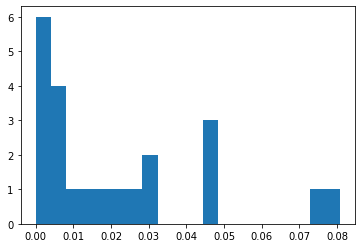

In [33]:
plt.hist(np.array(feat_importances['mean']), bins=20, label="Sklearn Feature Importances")
plt.show()

In [8]:
np.median(feat_importances['mean'])

0.01229470226564477

### Visualizations

Visualizing results. Horizontal Barplot, mean + median and p-value coloring

In [2]:
manual_imp = pd.read_csv("feature_importances/manual_classical_dummy_feature_importances.csv", index_col=0) 
final_manual_imp = pd.read_csv("feature_importances/final_manual_feature_importances.csv", index_col=0) 
final_final_manual_imp = pd.read_csv("feature_importances/final_final_manual_feature_importances.csv", index_col=0) 

In [3]:
manual_imp_mean = manual_imp['mean'].mean()
final_manual_imp_mean = final_manual_imp['mean'].mean()
final_final_manual_imp_mean = final_final_manual_imp['mean'].mean()
manual_imp_median = manual_imp['mean'].median()
final_manual_imp_median = final_manual_imp['mean'].median()
final_final_manual_imp_median = final_final_manual_imp['mean'].median()

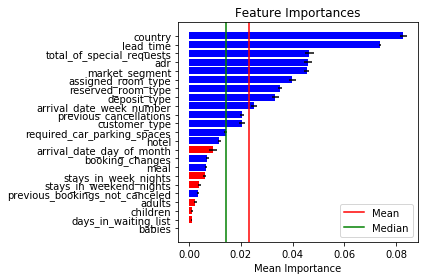

In [12]:
# Not important feats based on p-value: arrival_date_day_of_month, stays_in_week_nights, 
# stays_in_weekend_nights, adults, days_in_waiting_list, children and babies

fig, ax = plt.subplots()

cols = manual_imp.index
y_pos = np.arange(len(cols))
imp = manual_imp['mean']
std = manual_imp['std']

colors = ['b','r']
for (i,col) in zip(y_pos,cols):
    if col == "arrival_date_day_of_month" or col == "stays_in_week_nights" or col == "stays_in_weekend_nights" or col == "adults" or col == "days_in_waiting_list" or col == "children" or col == "babies":
        ax.barh(y_pos[i], imp[i], xerr=std[i], color = colors[1], align='center')
    else:
        ax.barh(y_pos[i], imp[i], xerr=std[i], color = colors[0], align='center')
    
plt.axvline(x=manual_imp_mean, color='r', label = r"Mean")
plt.axvline(x=manual_imp_median, color='g', label = r"Median")
ax.set_yticks(y_pos)
ax.set_yticklabels(cols)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Mean Importance')
ax.set_title('Feature Importances')
plt.legend()

plt.tight_layout()
plt.savefig('pictures/pimp_feat_imps.png', dpi=100)

plt.show()

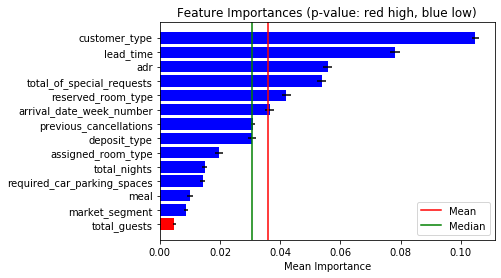

In [32]:
# Not important feats based on p-value: total_guests

fig, ax = plt.subplots()

cols = final_manual_imp.index
y_pos = np.arange(len(cols))
imp = final_manual_imp['mean']
std = final_manual_imp['std']

colors = ['b','r']
for (i,col) in zip(y_pos,cols):
    if col == "total_guests":
        ax.barh(y_pos[i], imp[i], xerr=std[i], color = colors[1], align='center')
    else:
        ax.barh(y_pos[i], imp[i], xerr=std[i], color = colors[0], align='center')
        
plt.axvline(x=final_manual_imp_mean, color='r', label = r"Mean")
plt.axvline(x=final_manual_imp_median, color='g', label = r"Median")
ax.set_yticks(y_pos)
ax.set_yticklabels(cols)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Mean Importance')
ax.set_title('Feature Importances (p-value: red high, blue low)')
plt.legend()

plt.show()

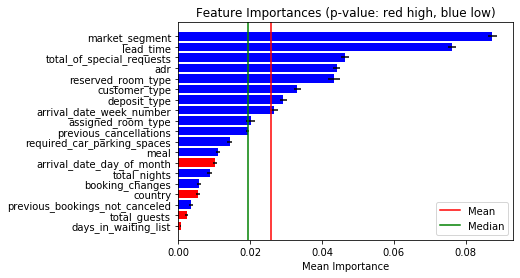

In [33]:
# Not important feats based on p-value: arrival_date_day_of_month, country, total_guests, days_in_waiting_list

fig, ax = plt.subplots()

cols = final_final_manual_imp.index
y_pos = np.arange(len(cols))
imp = final_final_manual_imp['mean']
std = final_final_manual_imp['std']

colors = ['b','r']
for (i,col) in zip(y_pos,cols):
    if col == "arrival_date_day_of_month" or col == "country" or col == "days_in_waiting_list" or col == "total_guests":
        ax.barh(y_pos[i], imp[i], xerr=std[i], color = colors[1], align='center')
    else:
        ax.barh(y_pos[i], imp[i], xerr=std[i], color = colors[0], align='center')
        
plt.axvline(x=final_final_manual_imp_mean, color='r', label = r"Mean")
plt.axvline(x=final_final_manual_imp_median, color='g', label = r"Median")
ax.set_yticks(y_pos)
ax.set_yticklabels(cols)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Mean Importance')
ax.set_title('Feature Importances (p-value: red high, blue low)')
plt.legend()

plt.show()